In [1]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from warnings import filterwarnings
filterwarnings('ignore')


In [2]:
df = pd.read_csv('btc_day_for_model.csv')
df.head()

,year_month_day,ma_20,ma_50,rsi,macd,macd_signal,bb_high,bb_low,roc,not,red_green,close
0,2017-09-19,3811.998,3869.626,45.858821,-148.398764,-119.000477,4983.369135,3372.315865,-16.658887,7342,red,3910.04
1,2017-09-20,3851.998,3846.589,45.663808,-141.402985,-123.480979,4909.680028,3363.515972,-8.938078,7231,red,3900.00
2,2017-09-21,3831.006,3786.741,40.328957,-157.445233,-130.273829,4810.598081,3340.105919,-15.234772,8714,red,3609.99
3,2017-09-22,3810.182,3729.956,40.083418,-169.346079,-138.088279,4771.403868,3291.673132,-12.940729,8152,green,3595.87
4,2017-09-23,3759.180,3713.487,44.802907,-162.051802,-142.880984,4708.618194,3281.550806,-10.181135,8402,green,3780.00


In [3]:
cls_df = df.drop(columns=['close'])
reg_df = df.drop(columns=['red_green'])

In [4]:
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2008 entries, 0 to 2007
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year_month_day  2008 non-null   object 
 1   ma_20           2008 non-null   float64
 2   ma_50           2008 non-null   float64
 3   rsi             2008 non-null   float64
 4   macd            2008 non-null   float64
 5   macd_signal     2008 non-null   float64
 6   bb_high         2008 non-null   float64
 7   bb_low          2008 non-null   float64
 8   roc             2008 non-null   float64
 9   not             2008 non-null   int64  
 10  close           2008 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 172.7+ KB


In [5]:
reg_df = reg_df.set_index('year_month_day')
reg_df.head()

,ma_20,ma_50,rsi,macd,macd_signal,bb_high,bb_low,roc,not,close
year_month_day,,,,,,,,,,
2017-09-19,3811.998,3869.626,45.858821,-148.398764,-119.000477,4983.369135,3372.315865,-16.658887,7342,3910.04
2017-09-20,3851.998,3846.589,45.663808,-141.402985,-123.480979,4909.680028,3363.515972,-8.938078,7231,3900.00
2017-09-21,3831.006,3786.741,40.328957,-157.445233,-130.273829,4810.598081,3340.105919,-15.234772,8714,3609.99
2017-09-22,3810.182,3729.956,40.083418,-169.346079,-138.088279,4771.403868,3291.673132,-12.940729,8152,3595.87
2017-09-23,3759.180,3713.487,44.802907,-162.051802,-142.880984,4708.618194,3281.550806,-10.181135,8402,3780.00


In [6]:
# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots



In [7]:
# Lets First Take all the Close Price 
closedf = reg_df[['close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (2008, 1)


In [8]:
fig = px.line(closedf, x=closedf.index, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Whole period of timeframe of Bitcoin close price 2017-2023', plot_bgcolor='white', 
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [9]:
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  2008


In [10]:
closedf

,close
year_month_day,
2017-09-19,3910.04
2017-09-20,3900.00
2017-09-21,3609.99
2017-09-22,3595.87
2017-09-23,3780.00
...,...
2023-03-13,24113.48
2023-03-14,24670.41
2023-03-15,24285.66


In [11]:
fig = px.line(closedf, x=closedf.index, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Bitcoin close price', 
                  plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [12]:
# Scaling
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf.close).reshape(-1,1))
print(closedf.shape)

(2008, 1)


In [16]:
training_size=int(len(closedf)*0.80)
test_size=len(closedf)-training_size
train_data, test_data=closedf[0:training_size,:], closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1606, 1)
test_data:  (402, 1)


In [18]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [19]:
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1575, 30)
y_train:  (1575,)
X_test:  (371, 30)
y_test (371,)


In [20]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1575, 30, 1)
X_test:  (371, 30, 1)


In [21]:
model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))


model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

In [22]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
50/50 [==============================] - 3s 23ms/step - loss: 0.0756 - val_loss: 0.0052
Epoch 2/200
50/50 [==============================] - 1s 12ms/step - loss: 0.0089 - val_loss: 0.0012
Epoch 3/200
50/50 [==============================] - 1s 12ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 4/200
50/50 [==============================] - 1s 11ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 5/200
50/50 [==============================] - 1s 12ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 6/200
50/50 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 6.5091e-04
Epoch 7/200
50/50 [==============================] - 1s 12ms/step - loss: 9.1940e-04 - val_loss: 6.3843e-04
Epoch 8/200
50/50 [==============================] - 1s 11ms/step - loss: 7.7657e-04 - val_loss: 5.4702e-04
Epoch 9/200
50/50 [==============================] - 1s 12ms/step - loss: 7.1754e-04 - val_loss: 6.5832e-04
Epoch 10/200
50/50 [==============================] - 1s 12ms/step - los

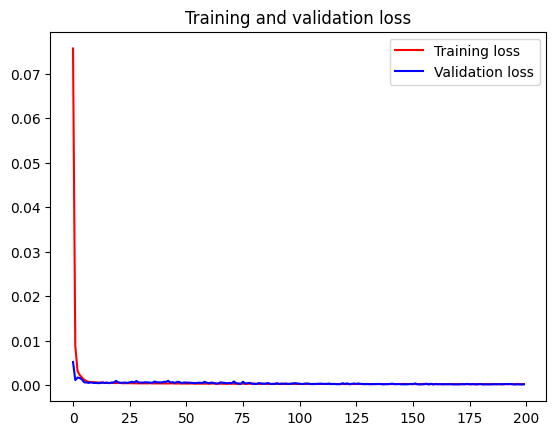

<Figure size 640x480 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [24]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

12/12 [==============================] - 0s 4ms/step


((1575, 1), (371, 1))

In [25]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [30]:
import math

# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  1022.6014436077508
Train data MSE:  1045713.7124686559
Train data MAE:  572.9038412388392
-------------------------------------------------------------------------------------
Test data RMSE:  996.5708602279957
Test data MSE:  993153.4794555674
Test data MAE:  723.7647889993261


In [31]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9966117592867639
Test data R2 score: 0.9850171128908332


In [27]:
# shift train predictions for plotting

look_back=30
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)



Train predicted data:  (2008, 1)


In [28]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(30*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)



Test predicted data:  (2008, 1)


In [29]:
names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock.index,
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [37]:
X_train_bst = X_train.reshape(1575, 30)

In [41]:
X_test_bst = X_test.reshape(371, 30)

In [43]:
y_train.shape

(1575,)

XGBoostRegressor

In [44]:
from xgboost import XGBRegressor

my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train_bst, y_train, verbose=1)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [45]:
predictions = my_model.predict(X_test_bst)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R2', r2_score(y_test, predictions))

Mean Absolute Error - MAE : 3939.12575524343
Root Mean squared Error - RMSE : 5349.852565351858
R2 0.5682197573548133


In [47]:
train_predict=my_model.predict(X_train_bst)
test_predict=my_model.predict(X_test_bst)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (1575, 1)
Test data prediction: (371, 1)


In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [48]:
look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': df['year_month_day'],
                       'original_close': df['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2008, 1)
Test predicted data:  (2008, 1)
